## Exploration_14_주식예측
1. 데이터 확인
2. ADF-Test (Augmented Dickey-Fuller Test)
3. ARIMA 모델 (설계, 학습, 결과확인)
4. 다른 주식에 대한 예측 (현대차, LG화학, POSCO)
5. 회고

### 1. 데이터 확인
#### 삼성(SAMSUNG)

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close'] # 종가(close)만 가져옴

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

#### 결측치 확인

In [157]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

* 결측치는 없다.

#### 데이터 그래프 확인

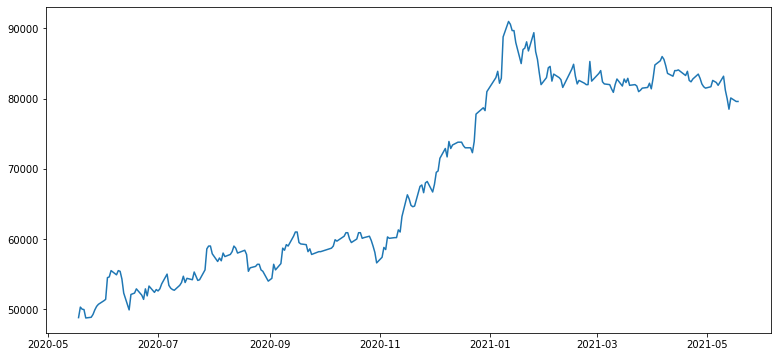

In [158]:
plt.plot(ts)

* 안정적(stationary)이지 않은 형태의 데이터임을 확인 할 수 있다.
* 따라서 추가 작업을 통해 데이터의 분포를 조절 할 필요가 있다.

#### 구간 통계치(Rolling Statistics)

In [159]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

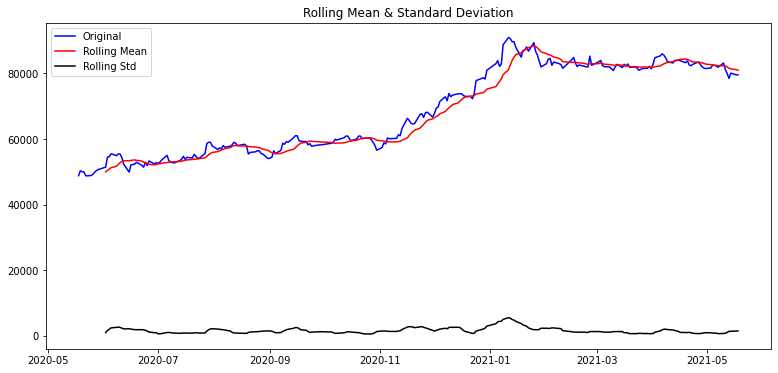

In [160]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

* windows 의 수 만큼 그룹화 된 데이터들의 평균(mean), 표준편차(std)를 구해 시각화 해본다. 이는 데이터의 전반적인 경향성을 확인해 보기 위함이다.
* 역시나 stationary 하지 않은 데이터 라는 것을 쉽게 알 수 있다.

### 2. Augmented Dickey-Fuller Test (ADF-Test)
#### ADF-Test는 아래의 순서대로 진행된다.
1. 현 데이터가 안정적이지 않다는 가설을 세운다.
2. 이 가설이 거짓임을 증명한다.
3. 따라서 이 데이터는 안정적이다는 결론을 내린다.
* Stationary 여부에 대한 판단은 p-value(probability value) 값을 기준으로 결정한다.

#### ADT-Test 함수

In [161]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### 현 데이터에 대한 결과값 확인

In [162]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


* p-value 가 0에 가까울 수록 stationary 하다고 볼 수 있으며, 최소 0.05 이하를 기준으로 판단한다.
* 따라서 이번 데이터의 경우 p-value 값이 상당히 높기 때문에 그만큼 stationary 하지 못하다고 볼 수 있다.

### Stationary 한 데이터로의 전환
#### 로그 함수 변환

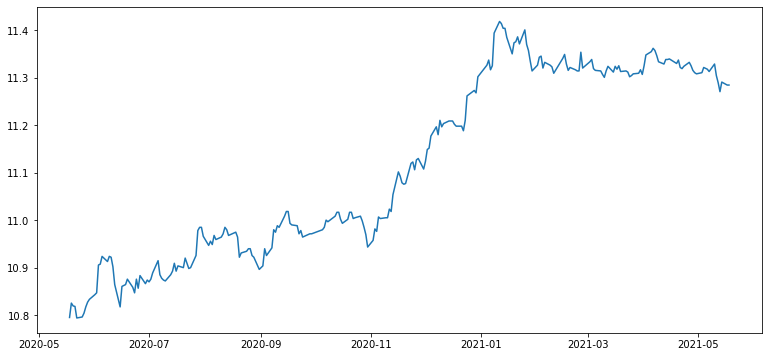

In [163]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [164]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


* 첫 번째 단계로 데이터를 log 값으로 변환 한 뒤 ADT-Test를 진행 해 보았다.
* 결과적으로 p-value가 조금 낮아지긴 했지만 여전히 상당히 높은 수치를 가지는 것을 알 수 있다. 따라서 추가적인 작업이 필요하다.

#### 추가 작업
- log로 변환 된 값의 p-value를 더 낮추기 위해 추가적으로 moving average(이동평균) 값을 구해서 빼주는 방식을 사용할 수 있다. 이 떄 windows-1 만큼 Nan 값이 생기기 때문에 이를 제거 해 주는 과정이 꼭 필요하다.
- 거기에 추가적으로 moving average shift 값을 구해서 빼주는 과정을 진행하면 우리가 원하는 p-value 값을 얻을 수 있게 된다.
- 이 모든 과정을 가능하게 해주는 것이 statsmodels 라이브러리의 seasonal_decompose 메소드 이며, 따라서 이를 이용한 방식으로 진행 하도록 하겠다.

### Seasonal_decompose method 활용

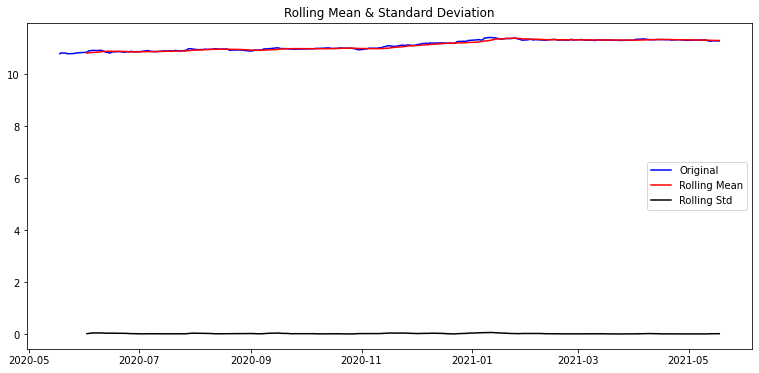

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


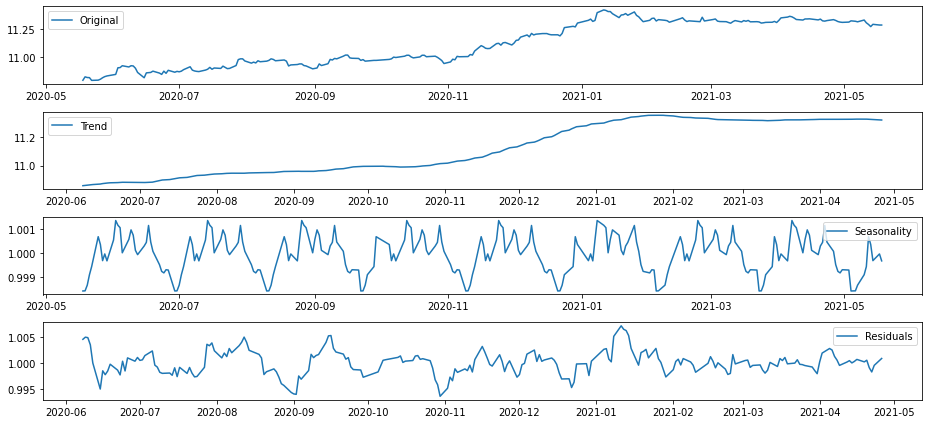

In [165]:
# 정성적 그래프 분석
# 데이터에 따라 window값을 알맞게 설정하는 것이 중요하다.
plot_rolling_statistics(ts_log, window=12) 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # Moving average
seasonal = decomposition.seasonal # Moving average shift
residual = decomposition.resid # 최종 결과

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* 위 부터 차례대로 원본데이터, trend, seasonality, 마지막으로 최종 결과인 residuals 의 그래프를 확인 할 수 있다.

In [166]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


* ADT-Test 결과 p-value 값이 상당히 낮게 나오는 걸 알 수 있고, 따라서 정상적으로 데이터가 stationary 한 형태로 변경되었다고 할 수 있다.

### 3. ARIMA 모델
#### 앞선 모든 과정을 모델의 형태로 유사하게 제공하는 것이 ARIMA 모델이다.
#### ARIMA는 내부적으로 3가지 모델을 포함한다.
1. AR(자기회귀, Autoregressive)
- 앞 과정에서의 'Residual' 부분을 모델링한다.
- 'p (AR의 시차)'를 parameter로 가진다.
2. MR(이동평균, Moving Average)
- 앞 과정의 'Trend' 부분을 모델링한다.
- 'q (MR의 시차)'를 parameter로 가진다.
3. I(차분누적, Integration) 
- 앞 과정의 'Seasonality' 부분을 모델링한다.
- 'd (차분 누적 횟수)'를 parameter로 가진다. 

#### 위의 3 가지 parameters를 적절하게 결정하는 것이 중요하며, 이를 위해 아래의 조건 및 방법을 사용한다.
- p + q < 2
- p x q = 0
- ACF(Autocorrelation Function)
- PACF(Partial Autocorrelation Function)

#### ACF, PACF (AR, MA)

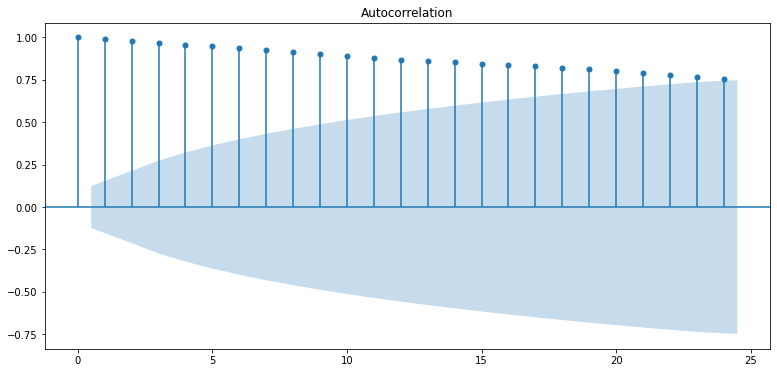

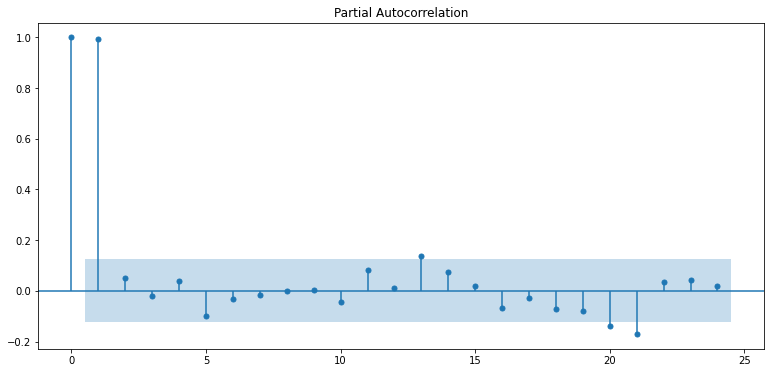

In [167]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* p, q 의 상관성은 아래 표를 따른다.
![](https://d3s0tskafalll9.cloudfront.net/media/images/E-16-4.max-800x600.png)

* 결론적으로 p 값은 1이 적당 (PACF 그래프에서 1 이후로 모두 0에 가까운 값으로 나타나기 때문에)하다고 할 수 있다.
* 반면에 q 값은 ACF 그래프를 참조 해야 되는데 딱히 어떤 값이 적당해 보인다고 결정 할 수가 없다.
* ARIMA 모델에서 데이터는 AR 또는 MA중 하나의 값을 따른다고 한다. 따라서 'p가 1'이고 'p x q = 0'이므로  'q는 0'이라고 생각할 수 있다.

#### Integration

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


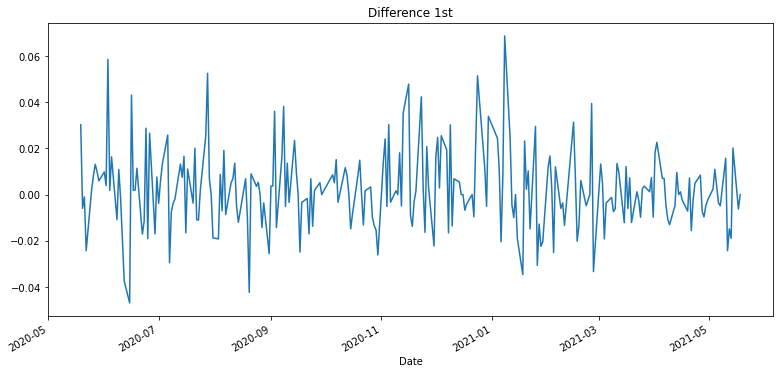

In [168]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

* 일단 차분(differencing)을 1회만 진행 했을 때 결과를 보면 p-value값이 상당히 낮게 측정 된 것을 알 수 있다.
* 따라서 2차를 추가적으로 진행할 필요는 없어보인다.

#### Train, Test set 분리
* 본격적으로 원본 데이터를 train, test로 분리하여 학습 해 보도록 한다.

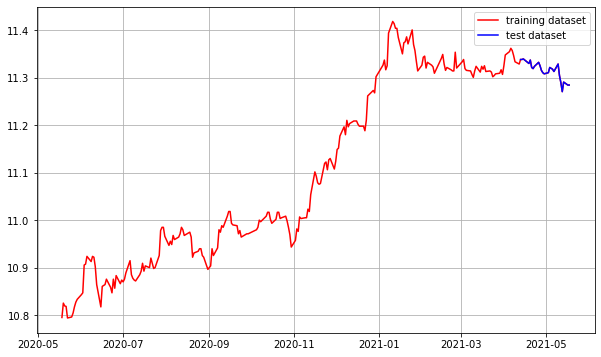

In [169]:
# Train : Test = 9 : 1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [170]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


* 나눠진 데이터의 그래프와 shape을 확인 해 보았다.

#### ARIMA 모델 훈련

In [171]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # (p, d, q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 03 Sep 2021   AIC                          -1164.792
Time:                        07:20:50   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

#### 결과확인

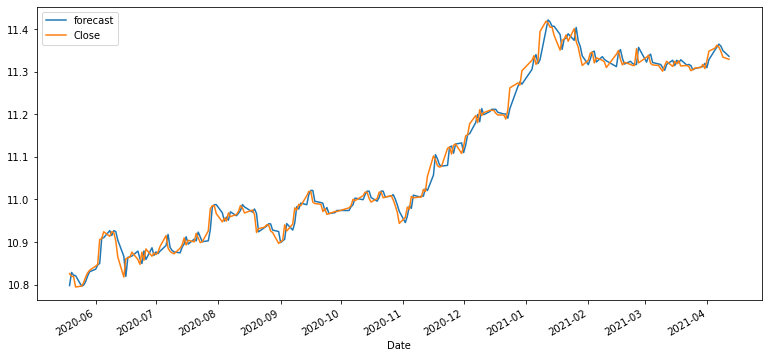

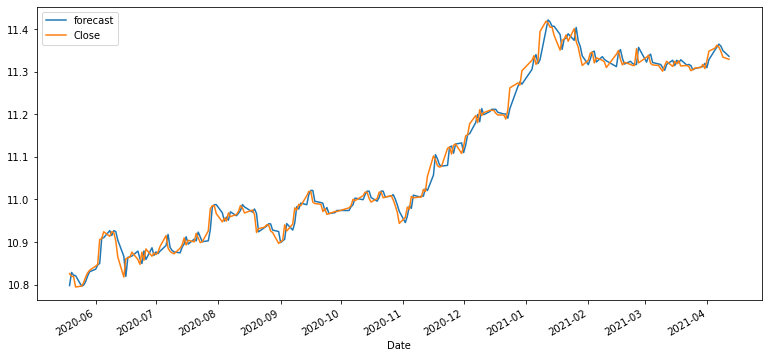

In [172]:
# 훈련 결과 시각화
fitted_m.plot_predict()

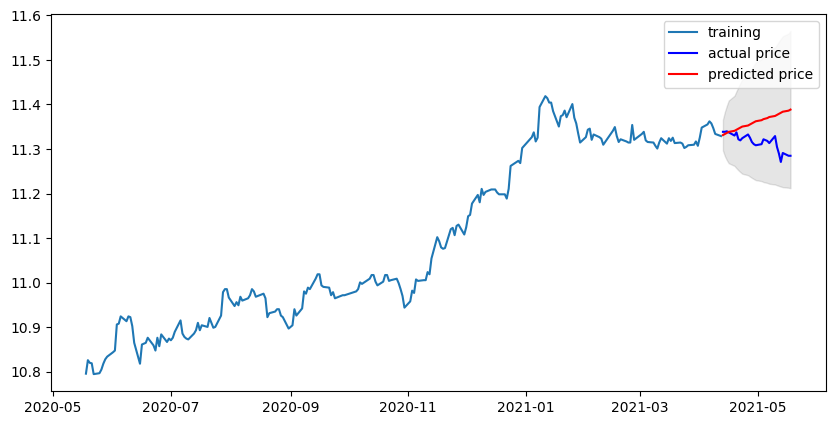

In [173]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

* 예측 결과는 붉은색으로, 실제 수치는 파란색으로 표시 된다.
* 상승할 것으로 예측 되었는데 실제로는 하락한 것을 볼 수 있다.

#### 오차 확인

In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


* 최종 결과에 대해 여러가지의 형태로 오차를 확인할 수 있다.
* 이 중에서 이번 과제에서는 MAPE에 초점을 맞추어 진행을 한다.<br>
1) MAPE는 오차가 예측값에서 차지하는 정도를 나타내는 지표이며, 0~100% 사이의 값을 가진다.<br>
2) 즉 MAPE 비율이 낮을 수록 신뢰도가 높은 예측 결과라고 해석할 수 있다.<br><br>
* 따라서 이번 결과를 보면 MAPE 수치가 4.68%로 신뢰도가 높은 모델이 만들어 졌다는 것을 알 수 있다.
* 하지만 결과적으로 보면 실제 값과 예측 값이 서로 상당히 다르기때문에, 아무리 신뢰도가 높은 예측값이라도 얼마든지 틀릴 수 있다는 것을 보여준다.

### 4. 다른 주식에 대한 예측
- 삼성 외의 다른 주식 정보에 대해 예측값을 구해보기로 한다.
- 데이터 외에는 완전히 동일한 방식이므로 추가적인 설명없이 코드만 작성하여 진행하였다.
- 마지막에 모든 주식에 대한 MAPE 값을 정리해 두었다.

#### 주가 정보 출처
- 현대차: https://finance.yahoo.com/quote/005380.KS?p=005380.KS&.tsrc=fin-srch
- LG화학: https://finance.yahoo.com/quote/051910.KS?p=051910.KS&.tsrc=fin-srch
- POSCO: https://finance.yahoo.com/quote/005490.KS?p=005490.KS&.tsrc=fin-srch

#### 1) 현대차

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath_2 = os.getenv('HOME') + '/aiffel/stock_prediction/005380.KS.csv' # 현대차
#dataset_filepath_3 = os.getenv('HOME') + '/aiffel/stock_prediction/051910.KS.csv' # LG화학
hd = pd.read_csv(dataset_filepath_2, index_col='Date', parse_dates=True)
#lg = pd.read_csv(dataset_filepath_3, index_col='Date', parse_dates=True)
ts = hd['Close']
#ts = lg['Close']

In [176]:
ts.head()

Date
2020-09-01    180000.0
2020-09-02    176000.0
2020-09-03    176500.0
2020-09-04    172500.0
2020-09-07    170000.0
Name: Close, dtype: float64

In [177]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

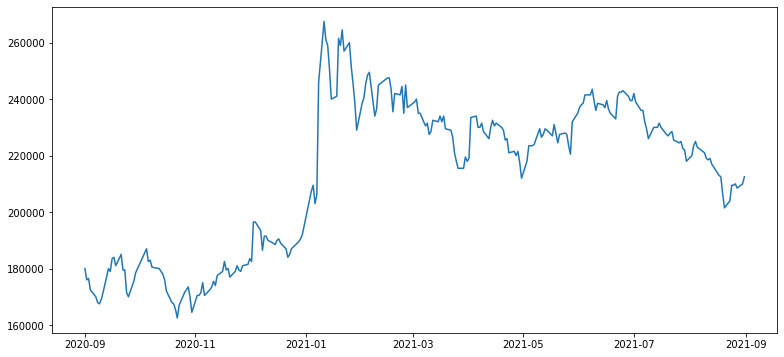

In [178]:
plt.plot(ts)

In [179]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

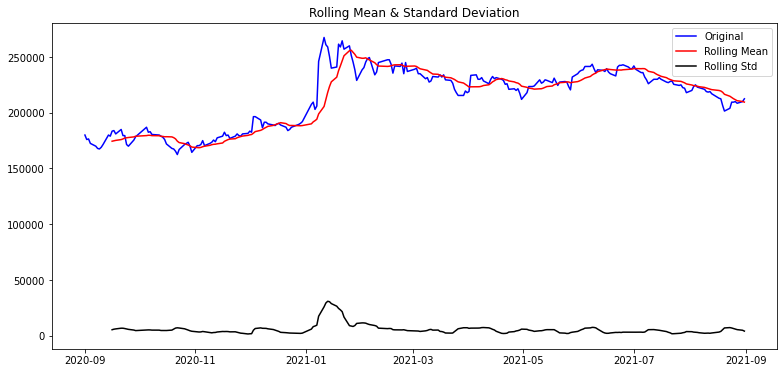

In [180]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [181]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [182]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.850682
p-value                          0.355605
#Lags Used                       8.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


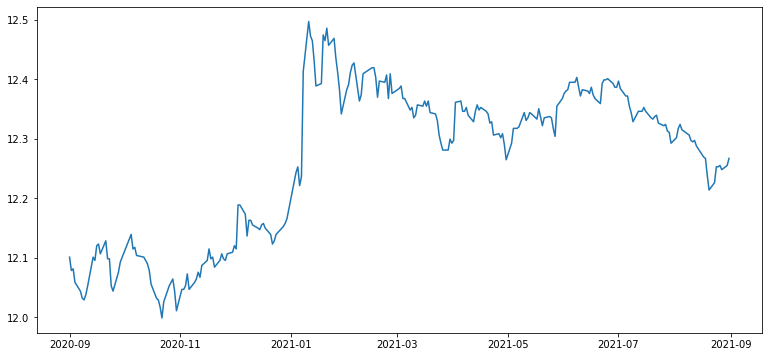

In [183]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

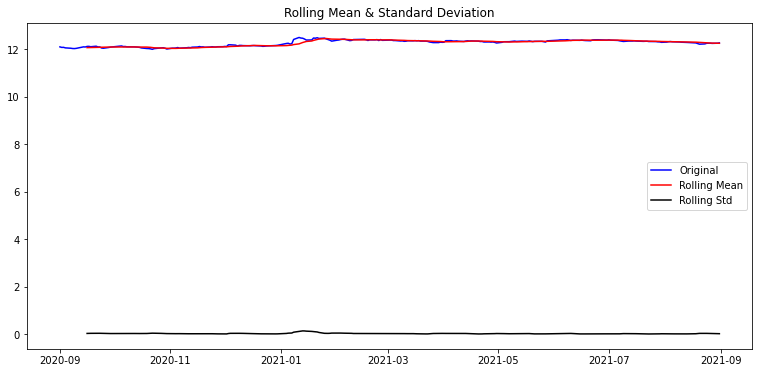

Results of Dickey-Fuller Test:
Test Statistic                  -1.844463
p-value                          0.358621
#Lags Used                       8.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


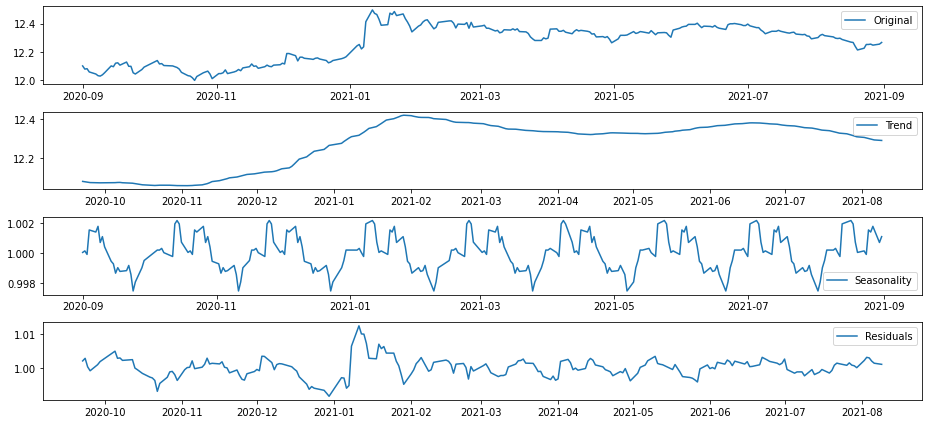

In [184]:
# 정성적 그래프 분석
# 데이터에 따라 window값을 알맞게 설정하는 것이 중요하다.
plot_rolling_statistics(ts_log, window=12) 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # Moving average
seasonal = decomposition.seasonal # Moving average shift
residual = decomposition.resid # 최종 결과

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [185]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.894714e+00
p-value                        2.869430e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


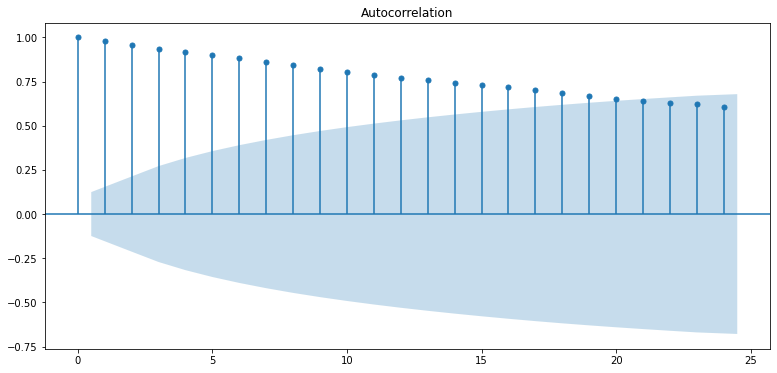

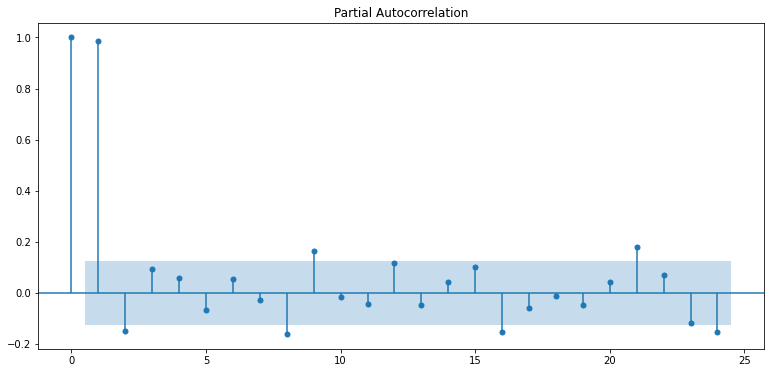

In [186]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.824365e+00
p-value                        4.112177e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


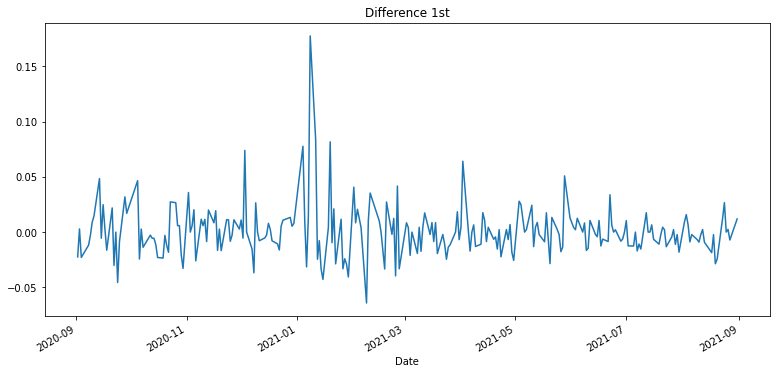

In [187]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

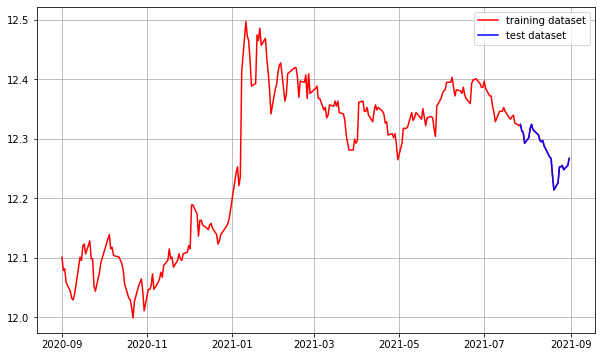

In [188]:
# Train : Test = 9 : 1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [189]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-01    12.100712
2020-09-02    12.078239
Name: Close, dtype: float64
(223,)
(25,)


In [190]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # (p, d, q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 512.734
Method:                       css-mle   S.D. of innovations              0.024
Date:                Fri, 03 Sep 2021   AIC                          -1019.469
Time:                        07:21:42   BIC                          -1009.261
Sample:                             1   HQIC                         -1015.347
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.002      0.551      0.582      -0.003       0.004
ar.L1.D.Close     0.0955      0.067      1.429      0.153      -0.035       0.226
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

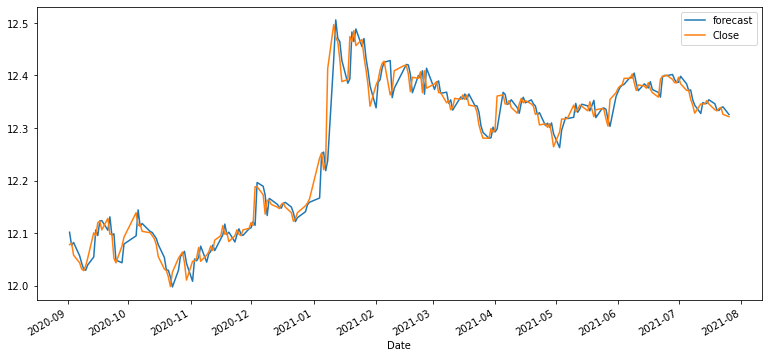

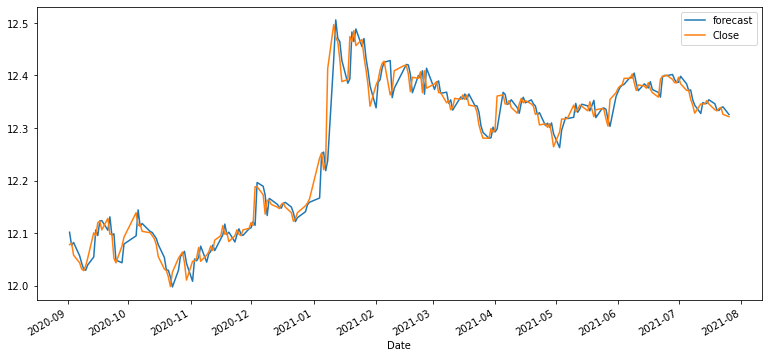

In [191]:
# 훈련 결과 시각화
fitted_m.plot_predict()

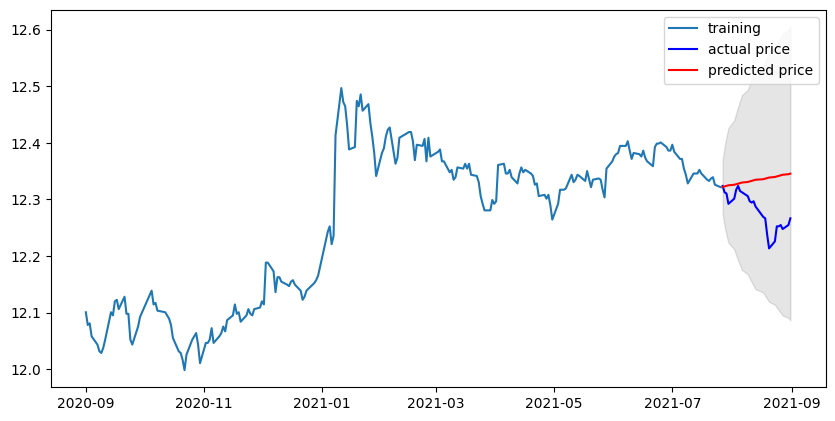

In [192]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [193]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  199206570.65882248
MAE:  11550.29051266382
RMSE:  14114.055783467149
MAPE: 5.48%


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------**
#### 2) LG화학

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
#dataset_filepath_2 = os.getenv('HOME') + '/aiffel/stock_prediction/005380.KS.csv' # 현대차
dataset_filepath_3 = os.getenv('HOME') + '/aiffel/stock_prediction/051910.KS.csv' # LG화학
#hd = pd.read_csv(dataset_filepath_2, index_col='Date', parse_dates=True)
lg = pd.read_csv(dataset_filepath_3, index_col='Date', parse_dates=True)
#ts = hd['Close']
ts = lg['Close']

In [195]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

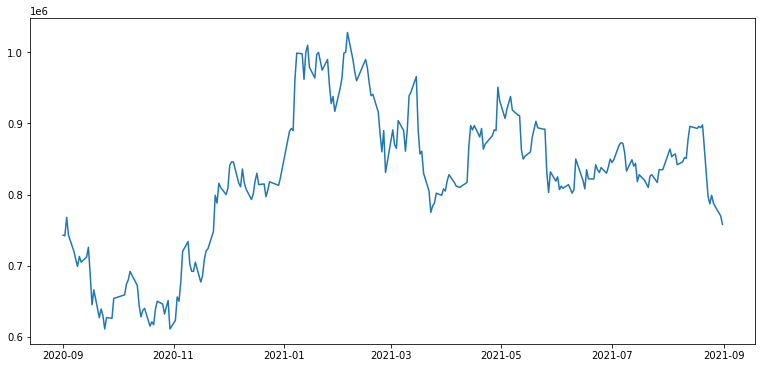

In [196]:
plt.plot(ts)

In [197]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

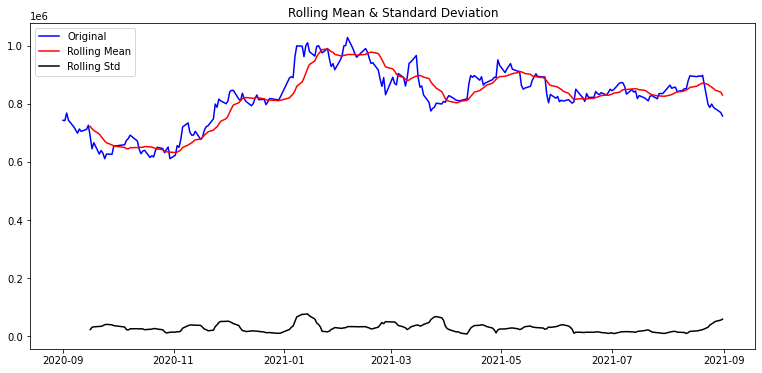

In [198]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [199]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [200]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.824504
p-value                          0.368366
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


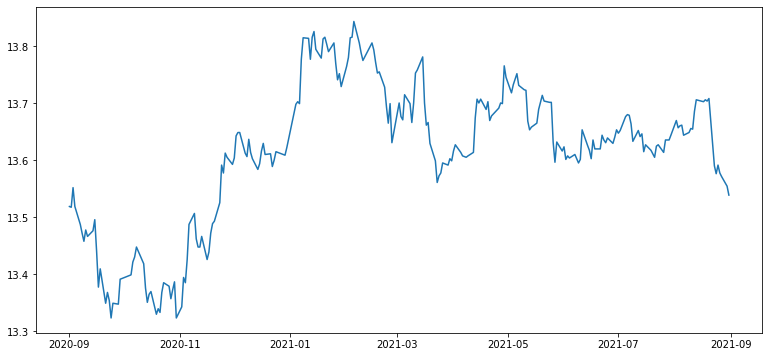

In [206]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [207]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.748748
p-value                          0.406187
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


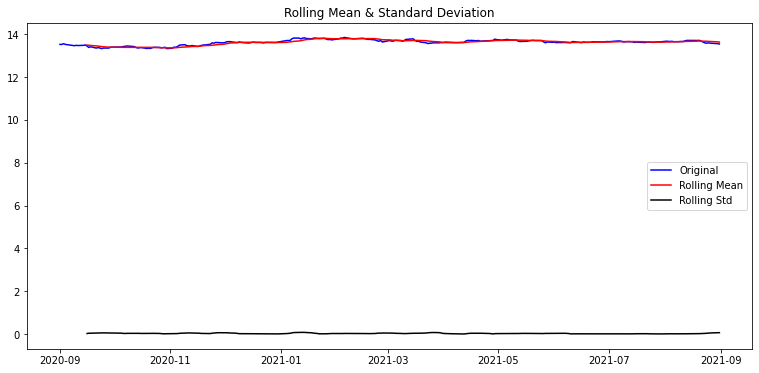

Results of Dickey-Fuller Test:
Test Statistic                  -1.748748
p-value                          0.406187
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


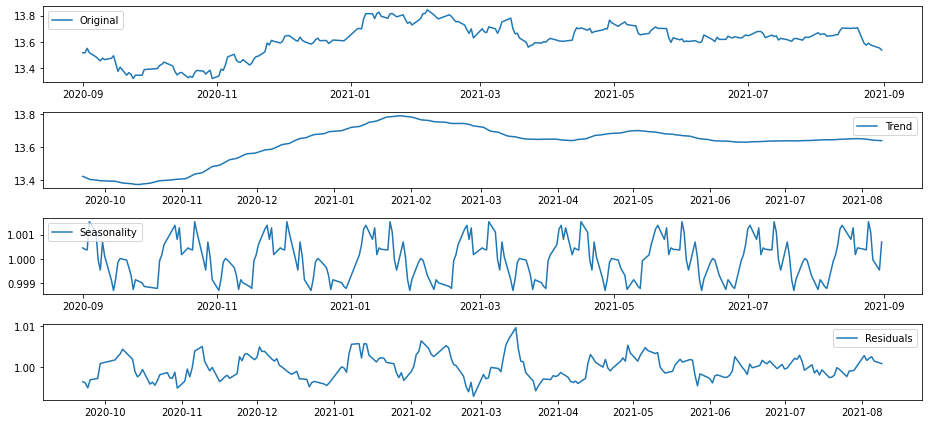

In [208]:
# 정성적 그래프 분석
# 데이터에 따라 window값을 알맞게 설정하는 것이 중요하다.
plot_rolling_statistics(ts_log, window=12) 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # Moving average
seasonal = decomposition.seasonal # Moving average shift
residual = decomposition.resid # 최종 결과

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [209]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.488852e+00
p-value                        1.241141e-08
#Lags Used                     4.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


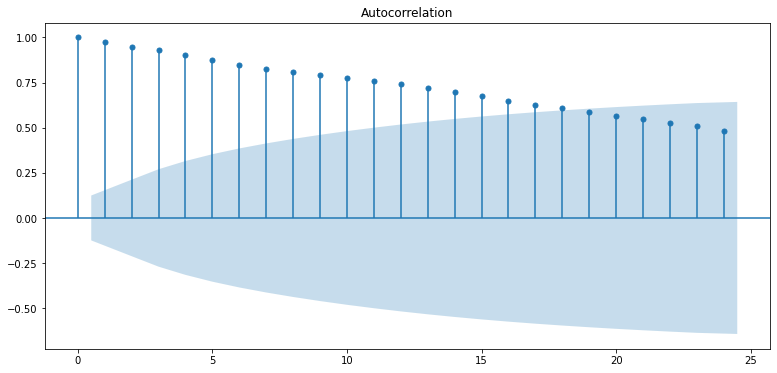

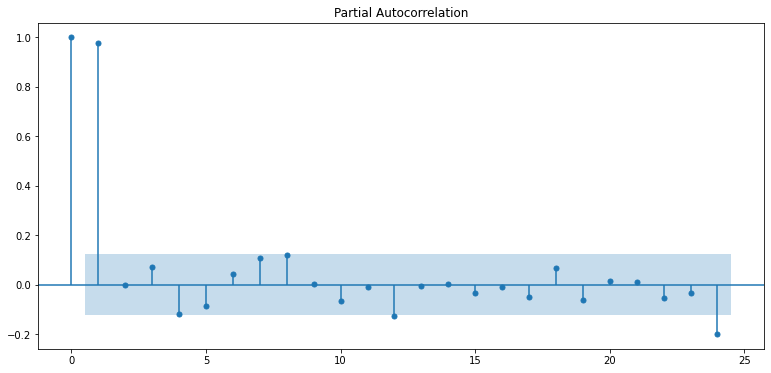

In [210]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.570042e+01
p-value                        1.398325e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


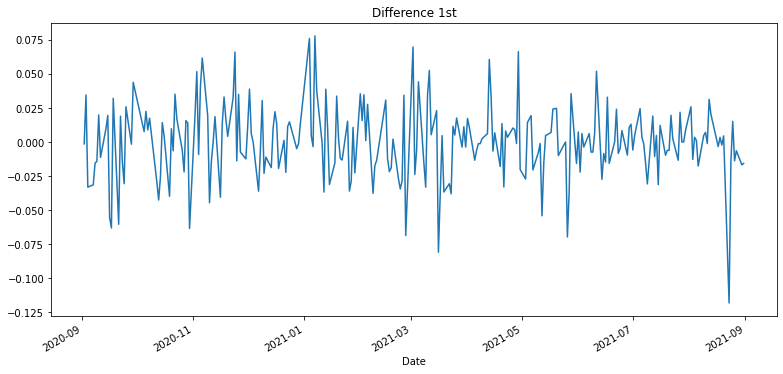

In [211]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

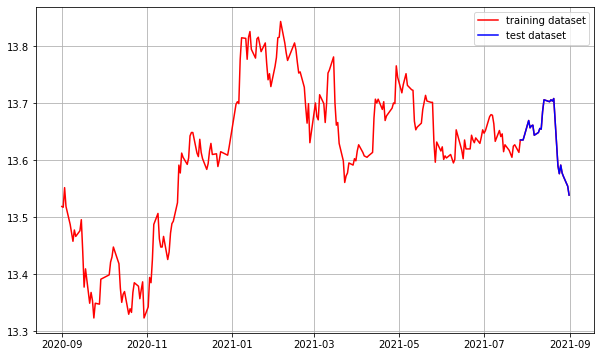

In [212]:
# Train : Test = 9 : 1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [213]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-01    13.518451
2020-09-02    13.517105
Name: Close, dtype: float64
(223,)
(25,)


In [214]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # (p, d, q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 486.270
Method:                       css-mle   S.D. of innovations              0.027
Date:                Fri, 03 Sep 2021   AIC                           -966.540
Time:                        07:24:43   BIC                           -956.332
Sample:                             1   HQIC                          -962.419
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.002      0.239      0.811      -0.003       0.004
ar.L1.D.Close    -0.0136      0.067     -0.202      0.840      -0.145       0.118
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

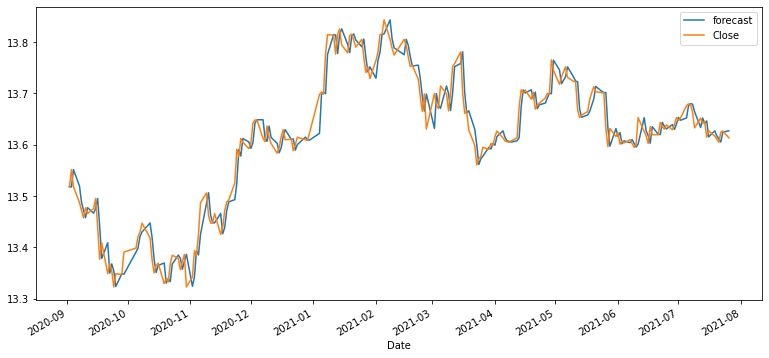

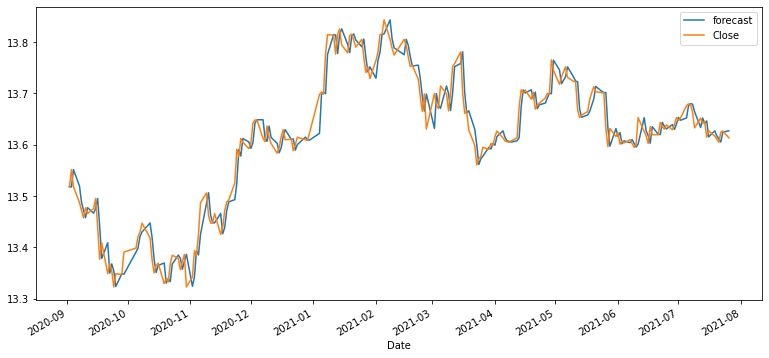

In [215]:
# 훈련 결과 시각화
fitted_m.plot_predict()

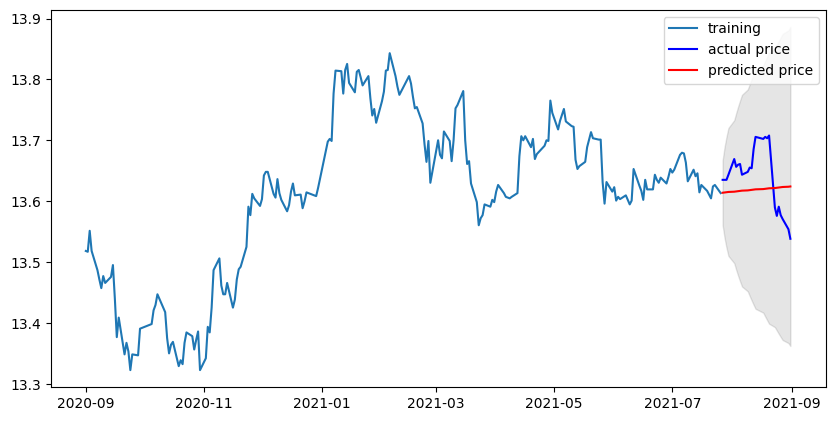

In [216]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [217]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2134509668.4681513
MAE:  41819.295225862435
RMSE:  46200.753981598085
MAPE: 4.95%


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------**
#### 3) POSCO

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath_4 = os.getenv('HOME') + '/aiffel/stock_prediction/005490.KS.csv' # POSCO
pc = pd.read_csv(dataset_filepath_4, index_col='Date', parse_dates=True)
ts = pc['Close']

In [219]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

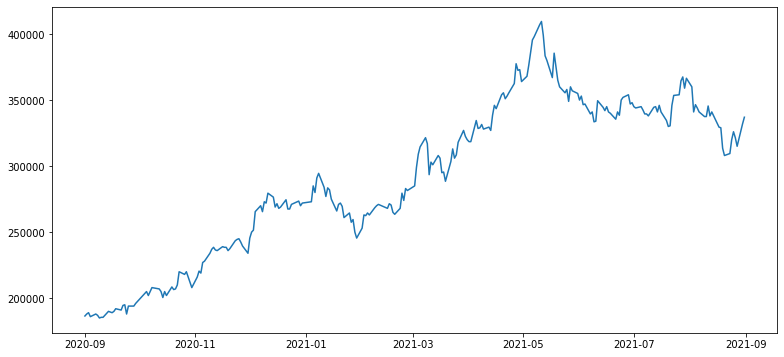

In [220]:
plt.plot(ts)

In [221]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

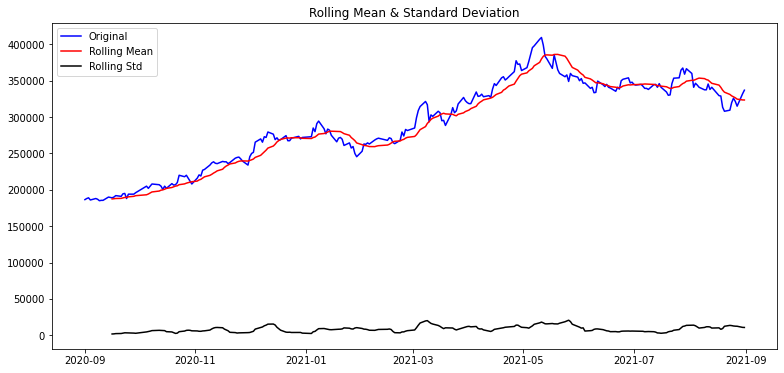

In [222]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [223]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [224]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.652654
p-value                          0.455657
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


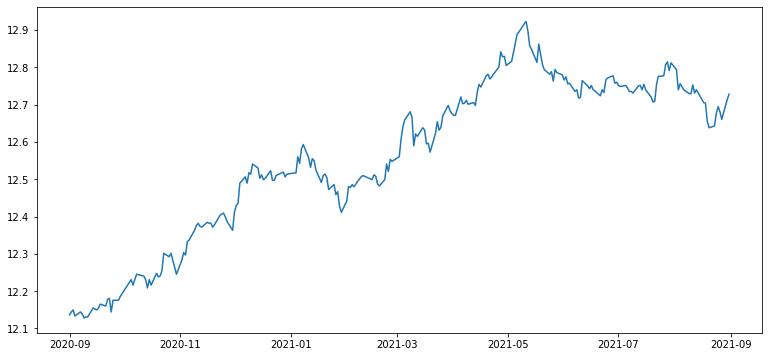

In [225]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [226]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.893021
p-value                          0.335351
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


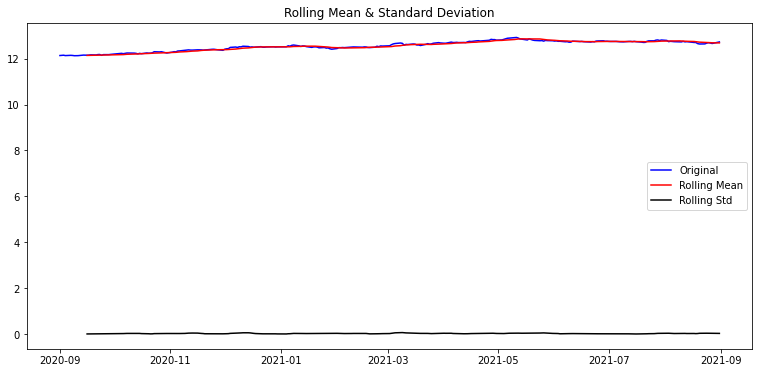

Results of Dickey-Fuller Test:
Test Statistic                  -1.893021
p-value                          0.335351
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


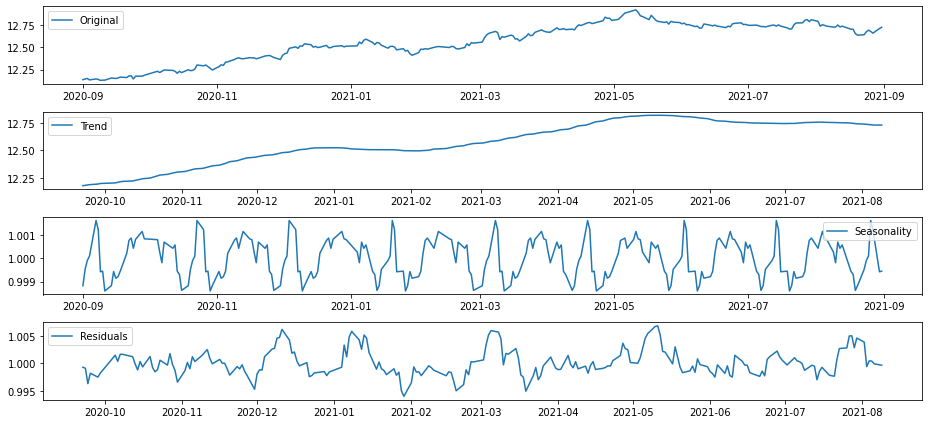

In [227]:
# 정성적 그래프 분석
# 데이터에 따라 window값을 알맞게 설정하는 것이 중요하다.
plot_rolling_statistics(ts_log, window=12) 

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # Moving average
seasonal = decomposition.seasonal # Moving average shift
residual = decomposition.resid # 최종 결과

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [228]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.248674
p-value                          0.000007
#Lags Used                       0.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


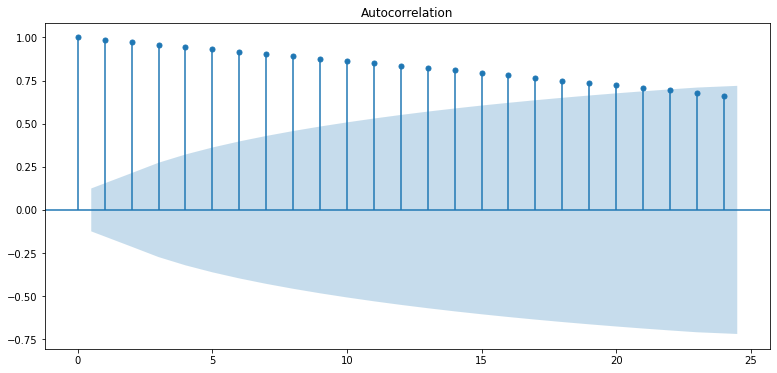

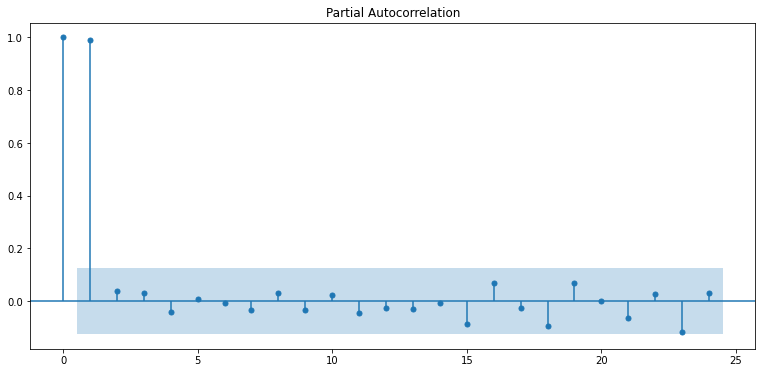

In [229]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.653566e+01
p-value                        2.004986e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


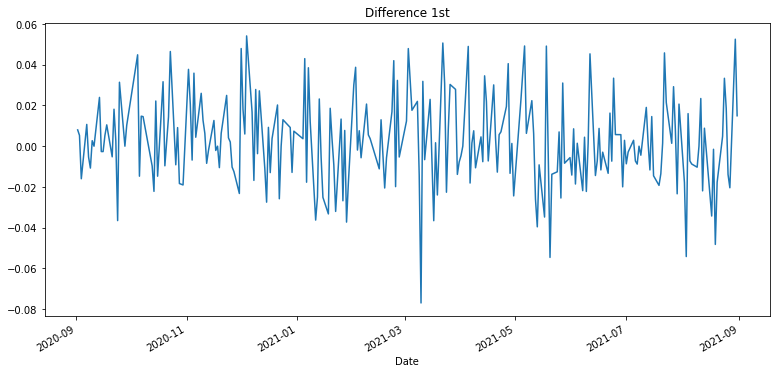

In [230]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

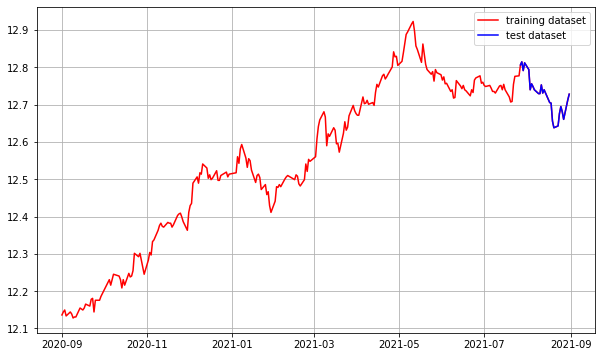

In [231]:
# Train : Test = 9 : 1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [232]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-01    12.136187
2020-09-02    12.144197
Name: Close, dtype: float64
(223,)
(25,)


In [233]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # (p, d, q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 540.045
Method:                       css-mle   S.D. of innovations              0.021
Date:                Fri, 03 Sep 2021   AIC                          -1074.090
Time:                        07:25:51   BIC                          -1063.882
Sample:                             1   HQIC                         -1069.969
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.001      2.162      0.031       0.000       0.006
ar.L1.D.Close    -0.0686      0.067     -1.027      0.305      -0.200       0.062
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

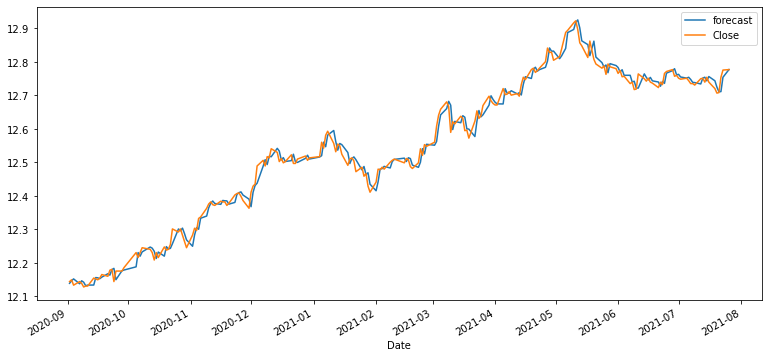

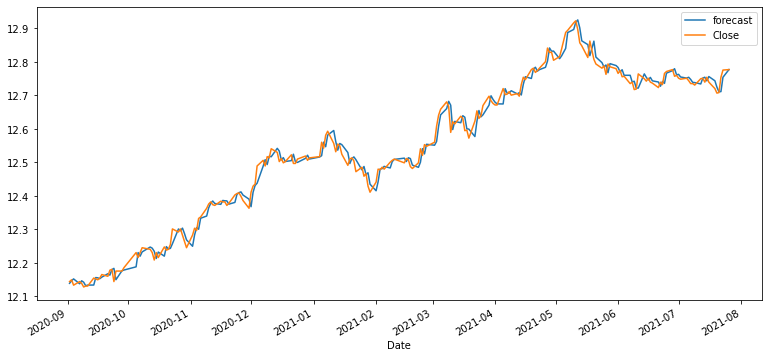

In [234]:
# 훈련 결과 시각화
fitted_m.plot_predict()

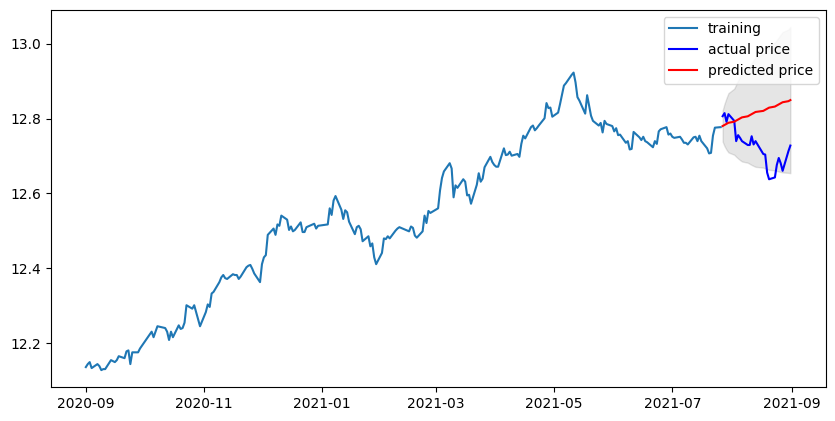

In [235]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [236]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1489628366.8122323
MAE:  32980.70350070385
RMSE:  38595.70399425605
MAPE: 10.09%


* 최종 결과<br>
1) 삼성: MAPE 4.68%<br>
2) 현대차: MAPE 5.48%<br>
3) LG화학: MAPE 4.95%<br>
4) POSCO: MAPE 10.09%<br><br>
* 모든 테스트에서 목표치인 MAPE 15% 이하의 결과를 얻었다.

### 5. 회고

* 이번 과제는 시계열 데이터를 안정화 시키는 방법에 대한 내용이었다.
* 데이터의 안정성(staitionary)라는 것은 얼만큼 데이터가 일정한 간격내에서 일정한 형태로 분포하는가를 나타내는 지표라는 것을 새롭게 알게 되었다.
* 그리고 불안정한 데이터를 안정화의 형태로 만들어가는 과정이 상세히 설명 되어 있었기에 어렵지 않게 전 과정을 이해할 수 있었다.
* 특히 한번에 데이터를 안정화 된 형태로 변경할 수 있는 seasonal_decompose method를 사용하는 방법이 편리했고, 그리고 이런 과정들을 자동으로 가능하게 해주는 ARIMA 라는 모델을 사용한 방법 또한 상당히 편리했다.
* 이 과정들을 거칠 때 중요한 점이 몇가지 있는데 window 값을 몇으로 지정하느냐에 따라 데이터의 형태가 변하기 때문에 주의해야 하고, ARMIA 모델을 사용할 때 parameter 'p', 'q', 'd'를 결정할 때 ACF, PACF를 통해 그래프의 형태로 먼저 구현 해 본 뒤에 상관관계표에 따라서 적절한 수치를 결정 해 주어야 하는 것 또한 중요하다. 이 parameter 수치에 따라 데이터의 크기 및 p-value 값들이 변경 되기 때문에 결과에 큰 영향을 미친다. 따라서 추후에 오차값이 나오게 되었을 때 내가 원하는 범위를 벗어나는 경우, 이 parameter들의 값을 조절 하며 오차 값을 줄여나가는 방향으로 모델을 수정해 나갈 수 있다.
* 또 한가지 인상적이었던 점은 일년치 정도의 데이터를 가지고 MAPE 값이 5~10% 정도의 나름 신뢰할 수 있는 예측 모델을 만들었음에도 불구하고 실제 주식의 값과 예측 값을 비교 해 봤을 때, 꽤나 큰 차이가 나는 것을 볼 수 있었다. 만약 10년치 정도의 데이터가 사용되었다면 다른 결과가 나왔을지도 모르지만, 주식이라는 변동성이 상당히 큰 데이터의 경우 역시 모델의 성능만으로는 그 값을 정확히 예측하기는 힘들 수 있다 라는 생각이 들었다.
* 결론적으로, 처음 접하는 내용이었지만 그 만큼 새로운 내용을 많이 알게 되었으며 따라서 꽤나 흥미롭게 진행 할 수 있었다.